## importing pakages

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## data fetching

<Axes: >

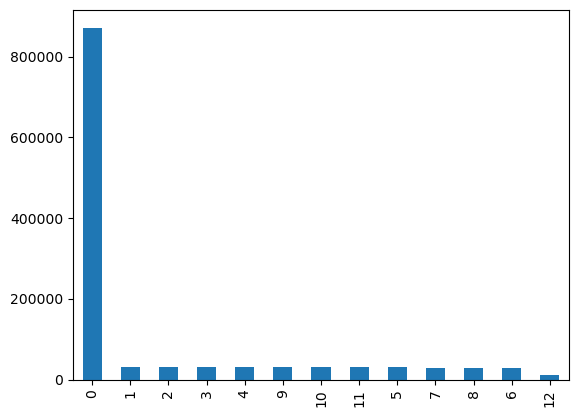

In [ ]:
df=pd.DataFrame()
for i in range(1,11):
    df1=pd.DataFrame()
    df1 = pd.read_csv(f'E:/ML/jupyter_notebooks/BTP/datasets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0:"acx",1:"acy",2:"acz",3:"es1",4:"es2",
        5:"alx", 6:"aly", 7:"alz", 8:"glx", 9:"gly", 10:"glz",11:"mlx",12:"mly",13:"mlz", 14:"arx",15:"ary", 16:"arz", 17:"grx", 18:"gry", 19:"grz",20:"mrx",21:"mry",22:"mrz", 23:"Activity"
        })
    df=pd.concat([df,df1])
pd.value_counts(df['Activity']).plot.bar()

## data resampling

In [ ]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

## creating clusters

In [ ]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

## creating workers

In [ ]:
workers_info=[]
enery_for_edge_at_start=100000
#data,cluster no ,edge score,model - coeff,model -intercept,energy consumed,acc
for i in range(5):
    for j in range(5):
        worker_data=pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id=i
        worker_score=0
        worker_coef=0
        worker_intercept=0
        worker_energy=[]
        energy_acc=[]
        energy=enery_for_edge_at_start
        workers_info.append([worker_data,worker_id,worker_coef,worker_score,worker_intercept,worker_energy,energy_acc,energy])

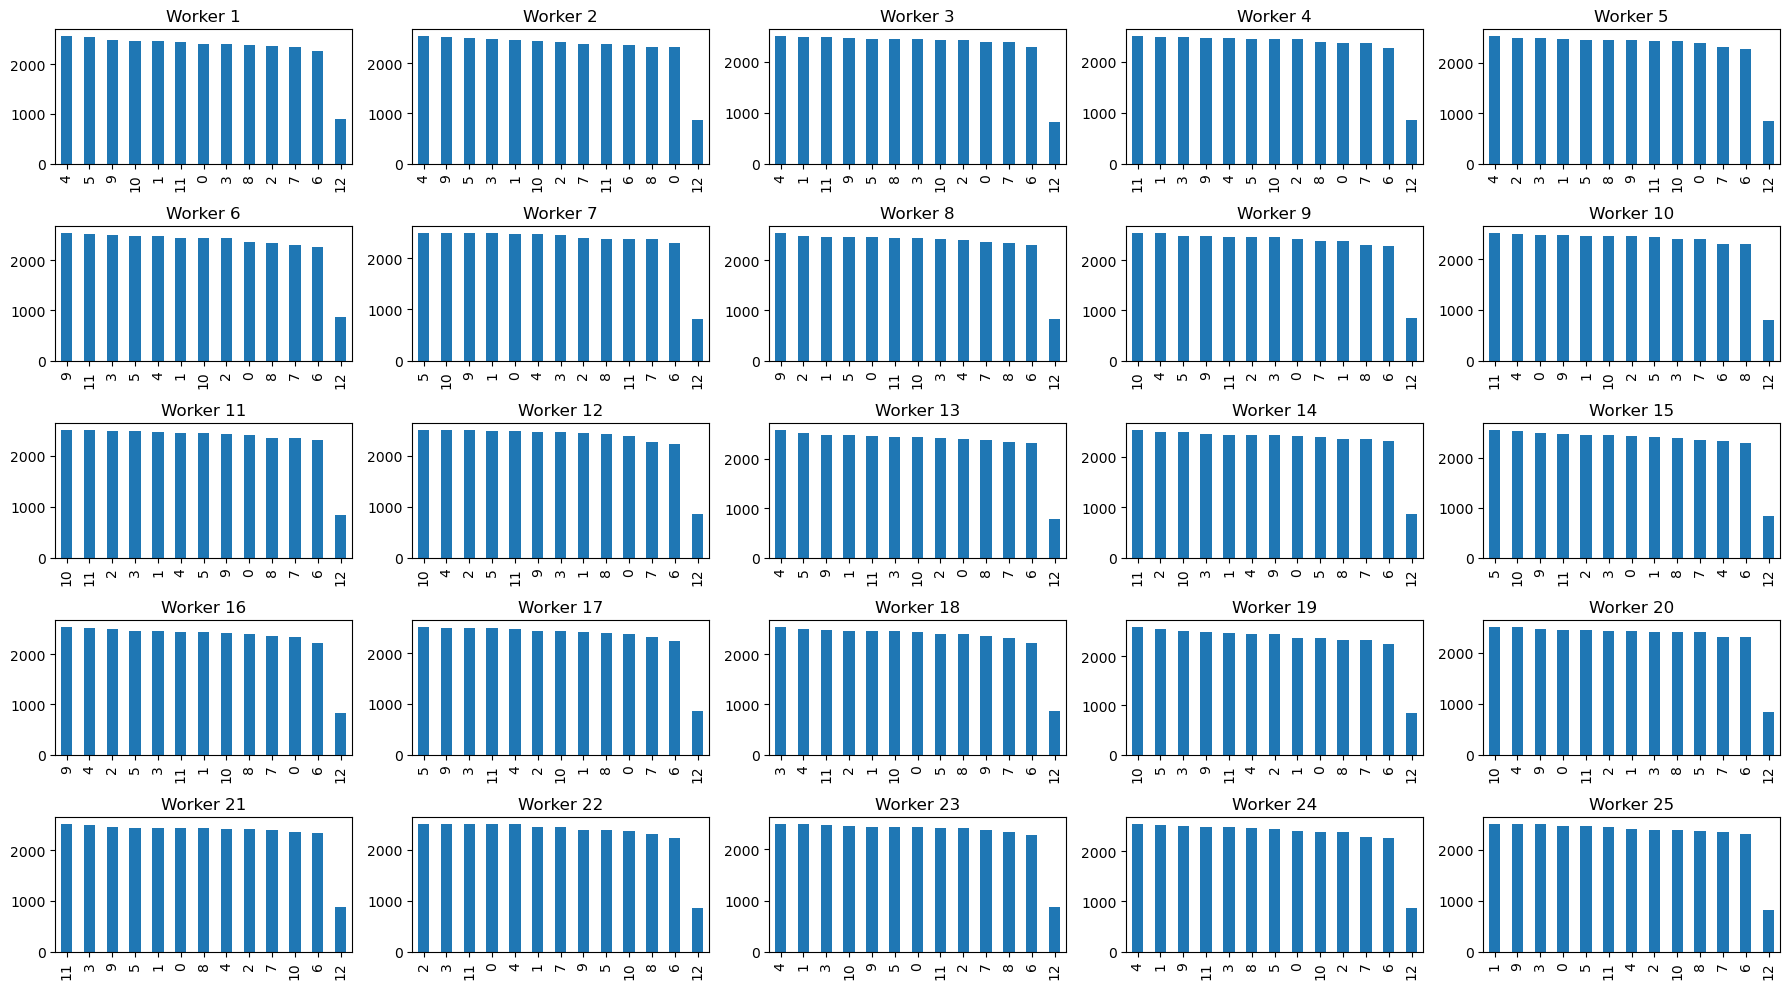

In [ ]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
  ax = fig.add_subplot(5, 5, i+1)
  pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
  ax.set_title(f'Worker {i+1}')
fig.tight_layout()
plt.show()

declaring a numpy array to store energy available to each worker and coeffiecient ,y_iintercept for worker model

In [ ]:
def extract(message):
  message_pack_container = msgpack.unpackb(message)
  compressed_byte_array = message_pack_container[0]
  decompressed_byte_array = gzip.decompress(compressed_byte_array)
  array = msgpack.unpackb(decompressed_byte_array)
  return np.array(array)
def compress(weights):
    byte_array = msgpack.packb(weights.tolist())
    compressed_byte_array = gzip.compress(byte_array)
    # Store the compressed byte array in a MessagePack container
    message_pack_container = msgpack.packb([compressed_byte_array])
    return message_pack_container

In [ ]:
 max_rounds = 100  # Maximum number of training rounds
 req_accuracy = 0.80  # Minimum accuracy threshold
 negligible_change = 0.0001  # Change in accuracy to be considered negligible
 energy_for_each_iteration=0.01
 num_of_workers=25
def energy_for_transmit(data):
    power=1
    #energy=power *time=time=data/power=data
    return data
def terminate(accuracy,best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False
def local_worker_training(worker_num):
    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train=ltrain.drop('Activity',axis=1)
    ly_train = ltrain['Activity']
    lX_test=ltest.drop('Activity',axis=1)
    ly_test = ltest['Activity']
    model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None)
    current_round = 0
    best_accuracy = 0.0
    energy_comsuption_in_local=0
    if(worker_num in cluster_heads and workers_info[worker_num][2]!=[]):
        #energy for receiving and sending
        energy_comsuption_in_local=energy_for_transmit(sys.getsizeof(workers_info[worker_num][5])+sys.getsizeof(workers_info[worker_num][6]))
        model.coef_=extract(workers_info[worker_num][2])
        model.intercept_=extract(workers_info[worker_num][4])
    while current_round < max_rounds:
        model.partial_fit(lX_train, ly_train, classes=[4, 11, 12,  0,  3,  7,  8, 10,  9,  2,  1,  5,  6])
        ly_pred = model.predict(lX_test)
        accuracy = accuracy_score(ly_test, ly_pred)
        if terminate(accuracy,best_accuracy):
            break
        best_accuracy = max(accuracy,best_accuracy)
        current_round += 1
    coeff_temp=model.coef_
    intercept_temp=model.intercept_
    energy_comsuption_in_local+=current_round*energy_for_each_iteration
    energy_comsuption_in_local+=energy_for_transmit(sys.getsizeof(coeff_temp)+sys.getsizeof(intercept_temp))
    workers_info[worker_num][2]=compress(coeff_temp)
    workers_info[worker_num][4]=compress(intercept_temp)
    workers_info[worker_num][5].append(energy_comsuption_in_local)
    workers_info[worker_num][6].append(best_accuracy)
    workers_info[worker_num][7]-=energy_comsuption_in_local
    print("local worker : ",worker_num ,"acc : ",best_accuracy," round no  ",current_round," energy remaining : ",workers_info[worker_num][7])

In [ ]:
def training_workers():
    for i in range(num_of_workers):
        local_worker_training(i)

In [ ]:
def cal_batter_life(energy_rem):
    return (energy_rem/enery_for_edge_at_start)*100

In [ ]:
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])

In [ ]:
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge

In [ ]:
def global_aggregation():
    training_workers()
    cal_edge_score()
    cal_clusters_head()
    global_model= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None)
    #print(workers_info[cluster_heads[0]][2],"\n",workers_info[cluster_heads[0]])
    avg_coef_=extract(workers_info[cluster_heads[0]][2])
    avg_intercept_=extract(workers_info[cluster_heads[0]][4])
    for i in range(1,num_of_clusters):
        avg_coef_ += extract(workers_info[i][2])
        avg_intercept_ += extract(workers_info[i][4])
    global_model.coef_=avg_coef_/num_of_workers
    global_model.intercept_=avg_intercept_/num_of_workers
    return global_model

In [ ]:
max_global_rounds=15
acc=[]
for i in range(max_global_rounds):
    global_model=global_aggregation()
    compressed_coef_=compress( global_model.coef_)
    compressed_intercept_=compress(global_model.intercept_)
    temp_max_acc=0
    for j in range(num_of_workers):
        workers_info[j][2]=compressed_coef_
        workers_info[j][4]=compressed_intercept_
        temp_max_acc=max(temp_max_acc,workers_info[j][6][i])
    acc.append(temp_max_acc)
    print("round - global ",i," acc ",temp_max_acc)
    #print("round no ", i," accuracy : ",)


local worker :  0 acc :  0.5435  round no   100  energy remaining :  91789.0
local worker :  1 acc :  0.5465  round no   100  energy remaining :  91789.0
local worker :  2 acc :  0.5468333333333333  round no   100  energy remaining :  91789.0
local worker :  3 acc :  0.5765  round no   100  energy remaining :  91613.0
local worker :  4 acc :  0.5561666666666667  round no   100  energy remaining :  91613.0
local worker :  5 acc :  0.5606666666666666  round no   100  energy remaining :  91613.0
local worker :  6 acc :  0.5435  round no   100  energy remaining :  91789.76
local worker :  7 acc :  0.5518333333333333  round no   100  energy remaining :  91613.0
local worker :  8 acc :  0.5463333333333333  round no   42  energy remaining :  91790.55
local worker :  9 acc :  0.5555  round no   100  energy remaining :  91789.82
local worker :  10 acc :  0.5626666666666666  round no   100  energy remaining :  91613.0
local worker :  11 acc :  0.547  round no   100  energy remaining :  91613.0
l

In [ ]:
total_energy_per_round=[]
energy_per_round=[]
total_energy=0
for i in range(15):
    energy=0
    for j in range(num_of_workers):
        total_energy+=workers_info[j][5][i]
        energy+=workers_info[j][5][i]
    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)
energy_per_round

[68422.87000000001,
 69301.55,
 69303.76,
 69303.89,
 69303.81,
 69622.89,
 69622.95000000001,
 69623.28,
 69623.24,
 70263.41,
 70263.58,
 70264.69,
 70263.55,
 70264.85,
 70263.48999999999]

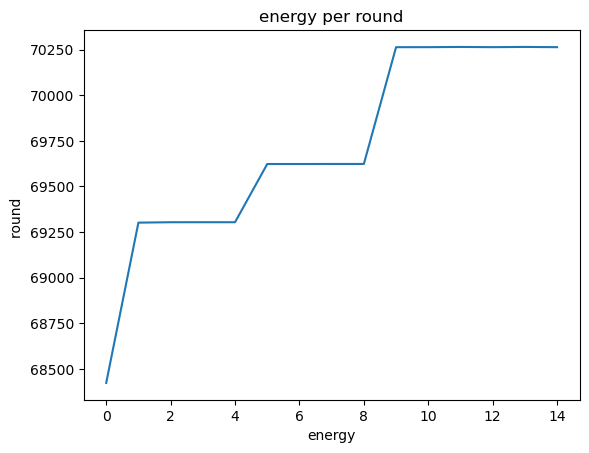

In [ ]:
plt.plot(energy_per_round)
plt.xlabel("energy")
plt.ylabel("round ")
plt.title("energy per round")
plt.show()

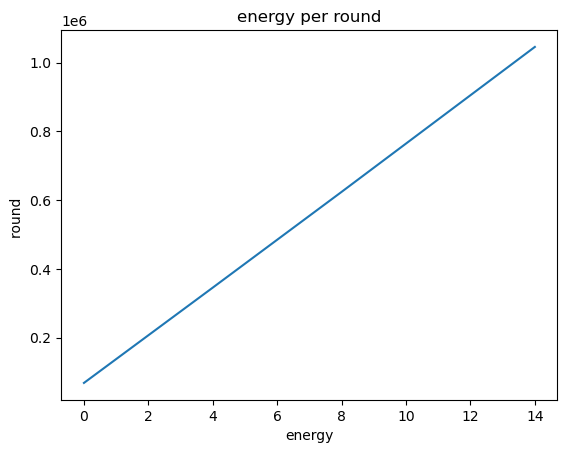

In [ ]:
plt.plot(total_energy_per_round)
plt.xlabel("energy")
plt.ylabel("round ")
plt.title("energy per round")
plt.show()